   # Predicting Financial Performance with Standardized Data and Hierarchical Forecasting
    
   ## We can improve net income forecasts by using industry and line item level detail as inputs to a hierarchical forecasting algorithm
   
   ### Following https://github.com/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb

![title](hierarchicaldiagram.jpg)

In [ ]:
# %#pip install statsforecast hierarchicalforecast utilsforcast

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive
import pandas as pd

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse
from hierarchicalforecast.methods import BottomUp
from hierarchicalforecast.utils import aggregate, HierarchicalPlot

from qgridnext import show_grid

In [9]:
TEST_PERIODS = 2

In [1]:
Y_df_load = pd.read_parquet("test_train_data.parquet")

## Build training data

In [5]:
levels = [
    ["market"],
    ["market", "top_level_SIC_code"],
    ["market", "top_level_SIC_code", "second_level_SIC_code"],
    ["market", "top_level_SIC_code", "second_level_SIC_code", "ticker"],
    ["market", "top_level_SIC_code", "second_level_SIC_code", "ticker", 'metric']
]

In [6]:
Y_df, S_df, tags = aggregate(df=Y_df_load, spec=levels)

In [7]:
Y_df = Y_df.reset_index()

In [10]:
Y_test_df = Y_df.groupby("unique_id").tail(TEST_PERIODS)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")

## Base Forecasts

In [28]:
season_length = 4
fcst = StatsForecast(
    models=[AutoARIMA(season_length=season_length)],
    freq="QE",
    fallback_model=SeasonalNaive(season_length=season_length),
    n_jobs=-1
)

In [29]:
Y_hat_df = fcst.forecast(
    df=Y_train_df,
    h=TEST_PERIODS,
    fitted=True,
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [32]:
Y_fitted_df = fcst.forecast_fitted_values()

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:1275: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


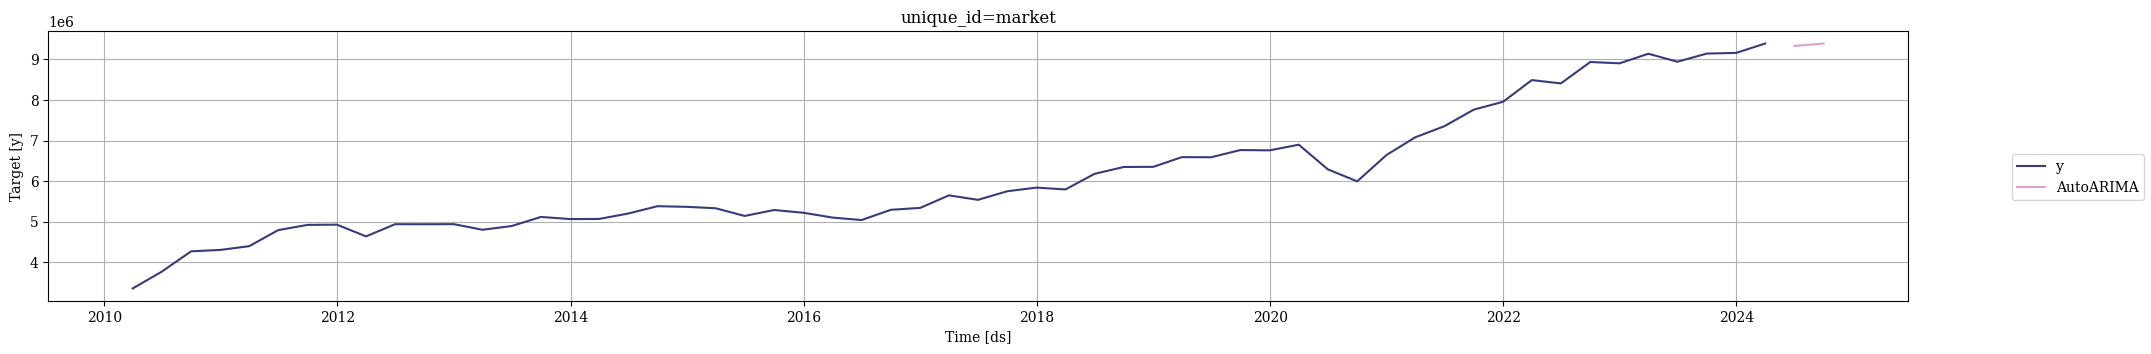

In [34]:
fcst.plot(
    Y_train_df,
    Y_hat_df,
    models=["AutoARIMA"],
    unique_ids=["market"],
)

## Hierarchical reconciliation

In [ ]:
hrec = HierarchicalReconciliation(
    reconcilers=[
        BottomUp(),
    ]
)

In [81]:
# Some records did not make it into Y_hat_df, think because they are 9

missing_records = S_df.index.unique().difference(Y_hat_df.index.unique())
S_df_minus_missing_records = S_df[~S_df.index.isin(missing_records)]

In [85]:
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S=S_df_minus_missing_records, tags=tags)

In [87]:
plot_df = pd.concat(
    [
        Y_df.reset_index().set_index(["unique_id", "ds"]),
        Y_rec_df.set_index("ds", append=True),
    ],
    axis=1,
)
plot_df = plot_df.reset_index("ds")

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_series(
    series="0",
    Y_df=plot_df,
    models=[
        "y",
        "AutoARIMA",
        "AutoARIMA/TopDown_method-forecast_proportions",
    ],
    level=[80],
)

In [ ]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
difference_df = Y_hat_df.merge(Y_test_df, on=["unique_id", "ds"])[
    ["ds", "AutoARIMA", "y"]
]

# hplot.plot_hierarchical_predictions_gap(Y_hat_df.rename({"Naive": "y"}, axis=1))

hplot.plot_hierarchical_predictions_gap(difference_df)

# Evaluation
## https://github.com/Nixtla/hierarchicalforecast/blob/2296c259542dbd906cfba4b8345c3b72148dad79/nbs/examples/TourismSmall.ipynb#L463

In [101]:
evaluator = HierarchicalEvaluation(evaluators=[mse])
evaluation = evaluator.evaluate(
    Y_hat_df=Y_rec_df,
    Y_test_df=Y_test_df,
    tags=tags,
    benchmark="AutoARIMA",
)

In [ ]:
tags["market/top_level_SIC_code/second_level_SIC_code/ticker/metric"] = tags[
    "market/top_level_SIC_code/second_level_SIC_code/ticker/metric"
][
    ~tags["market/top_level_SIC_code/second_level_SIC_code/ticker/metric"].isin(
        missing_records
    )
]

In [102]:
evaluation.T

level,Overall,market,market/top_level_SIC_code,market/top_level_SIC_code/second_level_SIC_code,market/top_level_SIC_code/second_level_SIC_code/ticker,market/top_level_SIC_code/second_level_SIC_code/ticker/metric
metric,mse-scaled,mse-scaled,mse-scaled,mse-scaled,mse-scaled,mse-scaled
AutoARIMA,1.0,1.0,1.0,1.0,1.0,1.0
AutoARIMA/BottomUp,0.594276,0.541308,0.62923,0.382817,0.920986,1.0


In [ ]:
show_grid(
    Y_rec_df.set_index(["ds"], append=True)
    .sub(Y_test_df.set_index(["ds"], append=True)["y"], axis="index")[
        ["AutoARIMA", "AutoARIMA/BottomUp"]
    ]
    .query('ds == "2024-06-30"')
)